In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

### Load the data

In [2]:
#open the locally saved csv
df = pd.read_csv('C:/Users/595217/general-assembly/project-final/data/mgm.csv', usecols=['description', 'jobtype', 'usetype'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 3 columns):
description    18000 non-null object
jobtype        18000 non-null object
usetype        18000 non-null object
dtypes: object(3)
memory usage: 422.0+ KB


### Create the features and target variables

In [4]:
df = df[df.usetype != 'Mixed Occupancy']

In [5]:
X = df['description']
y = df['usetype']
z = df['jobtype']

In [6]:
y = y.map({'Commercial': 0, 'Residential': 1})
z = z.map({'New': 0, 'Existing': 1, 'Alteration': 2, 'Repair': 3, 'Other': 4, 'Addition': 5})

In [7]:
y.value_counts(), z.value_counts()

(1    10651
 0     7329
 Name: usetype, dtype: int64, 0    4906
 1    4137
 2    3127
 3    2386
 4    2275
 5    1149
 Name: jobtype, dtype: int64)

In [8]:
# y_bin = label_binarize(y, classes=[0,1,2])
# n_y_bin_classes = y_bin.shape[1]
z_bin = label_binarize(z, classes=[0,1,2,3,4,5])
n_z_bin_classes = z_bin.shape[1]

In [10]:
X_tr, X_te, y_tr, y_te, = train_test_split(X, y, test_size=0.30, random_state=42)

In [16]:
# create the BOW representation
bow_transform = text.CountVectorizer(min_df=4, 
                                     stop_words="english", 
                                     ngram_range=(1, 4), max_features=1_000_000)
X_tr_bow = bow_transform.fit_transform(X_tr)
X_te_bow = bow_transform.transform(X_te)
len(bow_transform.vocabulary_)

26178

In [17]:
#create tf-idf representation using the bow matrix
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_trfm.transform(X_te_bow)
X_te_tfidf.shape

(5394, 26178)

In [21]:
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print(('Features: ', X_train_dtm.shape[1]))
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print(('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)))

In [20]:
vect = bow_transform

In [19]:
tokenize_test(vact)
vect.get_params()

NameError: name 'tokenize_test' is not defined

In [18]:
print((bow_transform.get_feature_names()[-50:]))

['yard 10 structures meet', 'yard 30', 'yard 30 rear', 'yard 30 rear yard', 'yard comply', 'yard comply state', 'yard comply state energy', 'yard coverage', 'yard existing', 'yard existing dwelling', 'yard existing dwelling meet', 'yard existing single', 'yard existing single family', 'yard foundation', 'yard foundation framing', 'yard foundation framing inspection', 'yard meet', 'yard meet applicable', 'yard meet applicable codes', 'yard property', 'yard property line', 'yard setback', 'yard setback flood', 'yard setback flood elev', 'yard variance', 'yard variance addition', 'yard variance addition come', 'yard variance maintain', 'yard variance maintain 14', 'yard yard', 'yards', 'yards meet', 'yards meet applicable', 'yards meet applicable codes', 'year', 'yoga', 'yoga studio', 'yoga studio inspections', 'yoga studio inspections required', 'youth', 'youth facility', 'zone', 'zoning', 'zoning approval', 'zoning comply', 'zoning comply state', 'zoning comply state energy', 'zoning de

### Instantiate a random forest classifier, run on the target variables and score the model

In [12]:
#instantiate the classifier
rf = RandomForestClassifier()

In [13]:
rf.fit(X_tr_tfidf, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
y_pred = rf.predict(X_te_tfidf)
print(rf.__class__.__name__, accuracy_score(y_te, y_pred))

RandomForestClassifier 0.9933899905571294


In [15]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("StDev:", scores.std())

In [16]:
y_tr_tfidf_scores = cross_val_score(rf, X_tr_tfidf, y_tr, cv=10, scoring="accuracy")

In [17]:
display_scores(y_tr_tfidf_scores)

Scores: [0.99352751 0.99595469 0.99514563 0.99595469 0.99029126 0.99110032
 0.99190939 0.98541329 0.99027553 0.99270665]
Mean: 0.9922278957058112
StDev: 0.0030591406276746004


In [18]:
y_te_tfidf_scores = cross_val_score(rf, X_te_tfidf, y_te, cv=10, scoring="accuracy")

In [19]:
display_scores(y_te_tfidf_scores)

Scores: [0.98681733 0.98870056 0.99245283 0.98865784 0.98298677 0.98865784
 0.98109641 0.98865784 0.98865784 0.97731569]
Mean: 0.98640009667075
StDev: 0.004298812611257222


In [20]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

C:\Users\595217\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
model = Sequential()

In [22]:
model.add(Dense(12, input_dim=8190, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, input_dim=8190, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, input_dim=8190, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, input_dim=8190, kernel_initializer='uniform', activation='sigmoid'))

In [23]:
model.output_shape

(None, 1)

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                98292     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 98,477
Trainable params: 98,477
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model.fit(X_tr_tfidf, y_tr, batch_size=32, epochs=100, verbose=1, validation_data=(X_te_tfidf, y_te))

Train on 12354 samples, validate on 5295 samples
Epoch 1/100
12354/12354 [==============================] - 3s 262us/step - loss: 0.1952 - acc: 0.9433 - val_loss: 0.0385 - val_acc: 0.9932
Epoch 2/100
12354/12354 [==============================] - 3s 275us/step - loss: 0.0388 - acc: 0.9926 - val_loss: 0.0348 - val_acc: 0.9930
Epoch 3/100
12354/12354 [==============================] - 3s 268us/step - loss: 0.0242 - acc: 0.9944 - val_loss: 0.0322 - val_acc: 0.9930
Epoch 4/100
12354/12354 [==============================] - 4s 314us/step - loss: 0.0159 - acc: 0.9964 - val_loss: 0.0318 - val_acc: 0.9930
Epoch 5/100
12354/12354 [==============================] - 3s 232us/step - loss: 0.0110 - acc: 0.9971 - val_loss: 0.0323 - val_acc: 0.9930
Epoch 6/100
12354/12354 [==============================] - 3s 231us/step - loss: 0.0070 - acc: 0.9983 - val_loss: 0.0353 - val_acc: 0.9917
Epoch 7/100
12354/12354 [==============================] - 3s 252us/step - loss: 0.0057 - acc: 0.9985 - val_loss: 0.0

In [27]:
score = model.evaluate(X_te_tfidf, y_te, batch_size=32)

5295/5295 [==============================] - 1s 115us/step


In [28]:
y_pred = model.predict(X_te_tfidf, batch_size=32)

### Convert predictions to text labels and join with the main dataframe to see where the errors occurred 

In [29]:
y_pred_classes = []
for i in y_pred:
    if i >= .5:
        y_pred_classes.append(1)
    else:
        y_pred_classes.append(0)

In [30]:
real_v_pred = pd.concat([y_te.reset_index(), pd.Series(y_pred_classes)], axis=1, join='inner', ignore_index=True).reset_index(drop=True).set_index([1])

In [31]:
real_v_pred.reset_index(inplace=True)
real_v_pred.columns = ['test', 'index', 'pred']

In [32]:
errors = real_v_pred[real_v_pred.test != real_v_pred.pred]
errors.set_index(keys='index', inplace=True)

In [33]:
df_errors = df.join(errors, how='inner')

In [34]:
df_errors.to_csv('df_errors.csv')

### Create a deep learning model with keras and compare to the random forest

In [35]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_te_tfidf).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_te, y_pred_keras)

In [36]:
y_pred_keras = model.predict(X_te_tfidf, batch_size=32).ravel()

In [37]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_te, y_pred_keras)

In [38]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [39]:
y_pred_rf = rf.predict_proba(X_te_tfidf)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_te, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

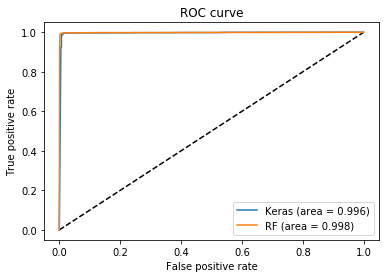

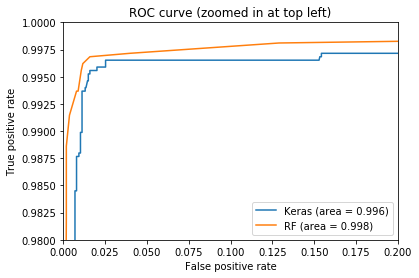

In [40]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.98, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [48]:
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
for train_idx, test_idx in sss.split(X_te_tfidf, y_te):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(f1_score(y_test, y_pred, average="macro"))
    print(precision_score(y_test, y_pred, average="macro"))
    print(recall_score(y_test, y_pred, average="macro"))

IndexError: index 283 is out of bounds for axis 0 with size 100

In [ ]:
A, b = make_classification(n_samples=100, n_informative=10, n_classes=3)

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.43      0.59      0.50        17
          1       0.60      0.53      0.56        17
          2       0.42      0.31      0.36        16

avg / total       0.49      0.48      0.48        50

